# House Price Prediction - Ensemble Conformal Quantile Regression Pipeline

## 1. Package Installation
*Install required machine learning libraries*

In [2]:
# !pip install catboost

## 2. Import Required Libraries
*Import essential data science and machine learning packages*

In [3]:
# 2: Import Libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 3. Define Evaluation Metrics (Winkler Score)
*Implement scoring functions for prediction interval evaluation*

In [4]:
# 3: Local Validation Metric (Winkler Score)
# This remains the same. A reliable local score is critical.
def winkler_score(y_true, lower, upper, alpha=0.1):
    score = upper - lower
    if y_true < lower:
        score += (2 / alpha) * (lower - y_true)
    elif y_true > upper:
        score += (2 / alpha) * (y_true - upper)
    return score

def mean_winkler_score(y_true, lower, upper, alpha=0.1):
    scores = [winkler_score(yt, l, u, alpha) for yt, l, u in zip(y_true, lower, upper)]
    return np.mean(scores) 

## 4. Data Loading and Memory Optimization
*Load datasets and optimize memory usage for efficient processing*

In [5]:
# 4: Data Loading and Memory Optimization
# This also remains the same.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

try:
    from pathlib import Path
    
    # Define project_root as the current working directory
    project_root = Path.cwd()
    base_dir = project_root / "data"

    train_path = base_dir / "dataset.csv"
    test_path  = base_dir / "test.csv"

    train_df_raw = pd.read_csv(train_path)
    test_df      = pd.read_csv(test_path)

    train_df_raw = reduce_mem_usage(train_df_raw)
    test_df = reduce_mem_usage(test_df)

    print("Data loaded and memory reduced.")

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    train_df_raw = pd.DataFrame()
    test_df = pd.DataFrame()

Mem. usage decreased to 24.99 Mb (65.2% reduction)
Mem. usage decreased to 24.22 Mb (65.5% reduction)
Data loaded and memory reduced.


## 5. Exploratory Data Analysis (EDA)

### 5.1 Target Variable Distribution Analysis
*Analyze sale price distribution and log transformation*

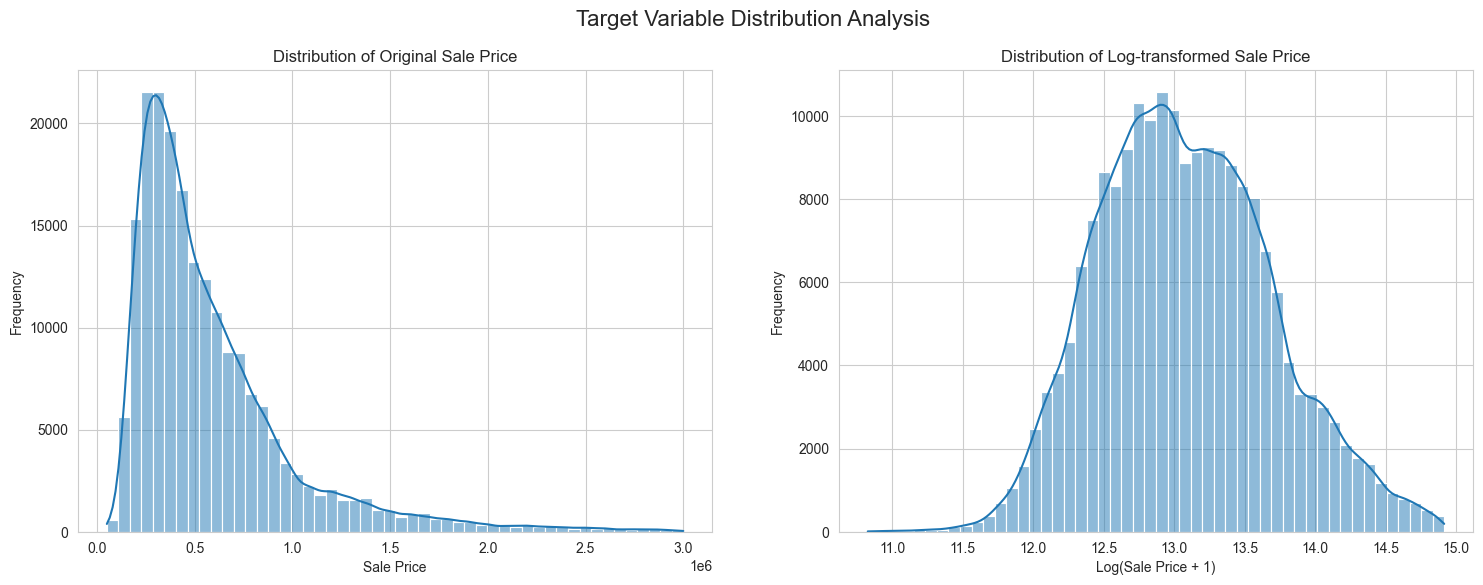

In [6]:
# 5: Exploratory Data Analysis (EDA) and Visualizations
if not train_df_raw.empty:
    # 5.1. Target Variable Analysis
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(train_df_raw['sale_price'], kde=True, bins=50)
    plt.title('Distribution of Original Sale Price')
    plt.xlabel('Sale Price')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(train_df_raw['sale_price']), kde=True, bins=50)
    plt.title('Distribution of Log-transformed Sale Price')
    plt.xlabel('Log(Sale Price + 1)')
    plt.ylabel('Frequency')

    plt.suptitle('Target Variable Distribution Analysis', fontsize=16)
    plt.show()



### 5.2 Dataset Overview
*Examine dataset structure, dimensions, and basic information*

In [7]:
train_df_raw.shape

(200000, 47)

In [8]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 47 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                200000 non-null  int32  
 1   sale_date         200000 non-null  object 
 2   sale_price        200000 non-null  int32  
 3   sale_nbr          157818 non-null  float32
 4   sale_warning      200000 non-null  object 
 5   join_status       200000 non-null  object 
 6   join_year         200000 non-null  int16  
 7   latitude          200000 non-null  float32
 8   longitude         200000 non-null  float32
 9   area              200000 non-null  int8   
 10  city              200000 non-null  object 
 11  zoning            200000 non-null  object 
 12  subdivision       182450 non-null  object 
 13  present_use       200000 non-null  int8   
 14  land_val          200000 non-null  int32  
 15  imp_val           200000 non-null  int32  
 16  year_built        20

In [9]:
train_df_raw.head()

,id,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,...,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
0,0,2014-11-15,236000,2.0,,nochg,2025,47.291698,-122.365799,53,...,0,0,0,0,0,0,0,0,0,I
1,1,1999-01-15,313300,NaN,26,nochg,2025,47.653099,-122.199600,74,...,0,0,0,0,0,1,0,0,0,Q
2,2,2006-08-15,341000,1.0,,nochg,2025,47.473301,-122.190102,30,...,0,0,0,0,0,0,0,0,0,K
3,3,1999-12-15,267000,1.0,,nochg,2025,47.473900,-122.329498,96,...,0,0,0,0,0,0,0,0,0,G
4,4,2018-07-15,1650000,2.0,,miss99,2025,47.751598,-122.122200,36,...,0,0,0,0,0,0,0,0,0,P


### 5.3 Missing Values Analysis
*Identify and quantify missing data patterns*

In [10]:
missing_values = train_df_raw.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

sale_nbr       42182
subdivision    17550
submarket       1717
dtype: int64

In [11]:
# Optional: Example of filling missing values
# train_df_raw['LotFrontage'] = train_df_raw['LotFrontage'].fillna(train_df_raw['LotFrontage'].median())

### 5.4 Statistical Summary
*Generate descriptive statistics for numerical features*

In [12]:
train_df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
id,200000.0,99999.500000,57735.171256,0.000000,49999.750000,99999.500000,149999.250000,1.999990e+05
sale_price,200000.0,584149.494690,417059.519757,50293.000000,305000.000000,459950.000000,724950.000000,2.999950e+06
sale_nbr,157818.0,2.162599,1.113090,1.000000,1.000000,2.000000,3.000000,1.100000e+01
join_year,200000.0,2023.403600,6.241643,1999.000000,2025.000000,2025.000000,2025.000000,2.025000e+03
latitude,200000.0,47.549252,0.142710,47.155201,47.446499,47.562801,47.673500,4.777780e+01
longitude,200000.0,-122.210442,0.140339,-122.527702,-122.323799,-122.222702,-122.121696,-1.211613e+02
area,200000.0,48.644215,27.132002,1.000000,26.000000,48.000000,71.000000,1.000000e+02
present_use,200000.0,4.108860,7.199323,2.000000,2.000000,2.000000,2.000000,2.900000e+01
land_val,200000.0,460169.092410,351044.447775,0.000000,231000.000000,377000.000000,594000.000000,1.386400e+07
imp_val,200000.0,491771.491330,368050.501496,0.000000,280000.000000,409000.000000,599000.000000,1.006700e+07


### 5.5 Categorical Features Analysis
*Examine unique value counts and categorical feature distributions*

In [13]:
# For categorical columns
train_df_raw.select_dtypes(include='object').nunique()

sale_date         313
sale_warning      142
join_status         8
city               41
zoning            500
subdivision     10376
submarket          19
dtype: int64

### 5.6 Outlier Detection
*Visualize outliers in target variable using boxplots*

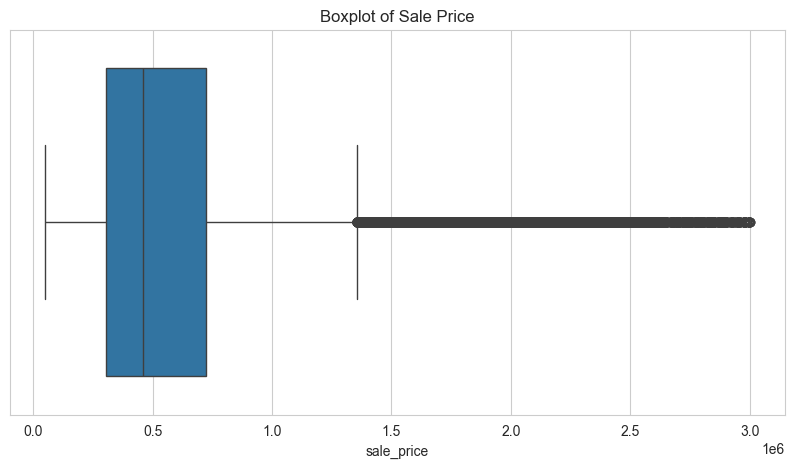

In [14]:
# Boxplot for outliers in Sale Price
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df_raw['sale_price'])
plt.title('Boxplot of Sale Price')
plt.show()

### 5.7 Feature Correlation Analysis
*Create correlation heatmap for numerical features*

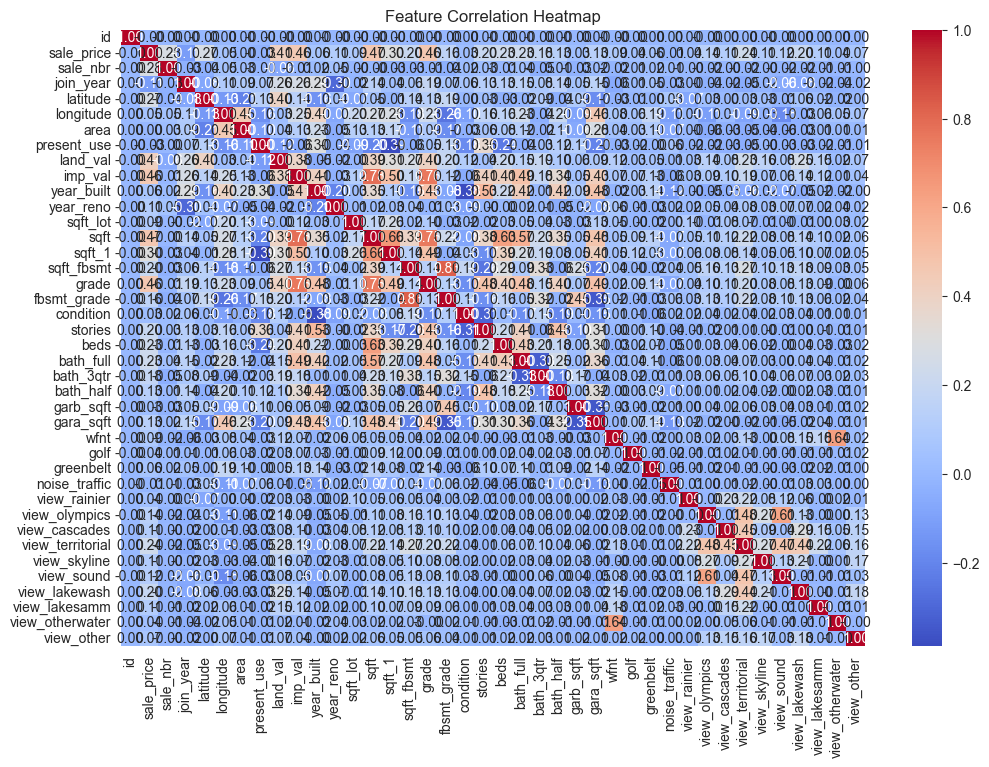

In [15]:
corr = train_df_raw.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### 5.8 Feature Relationships Visualization
*Explore relationships between key features and target variable*

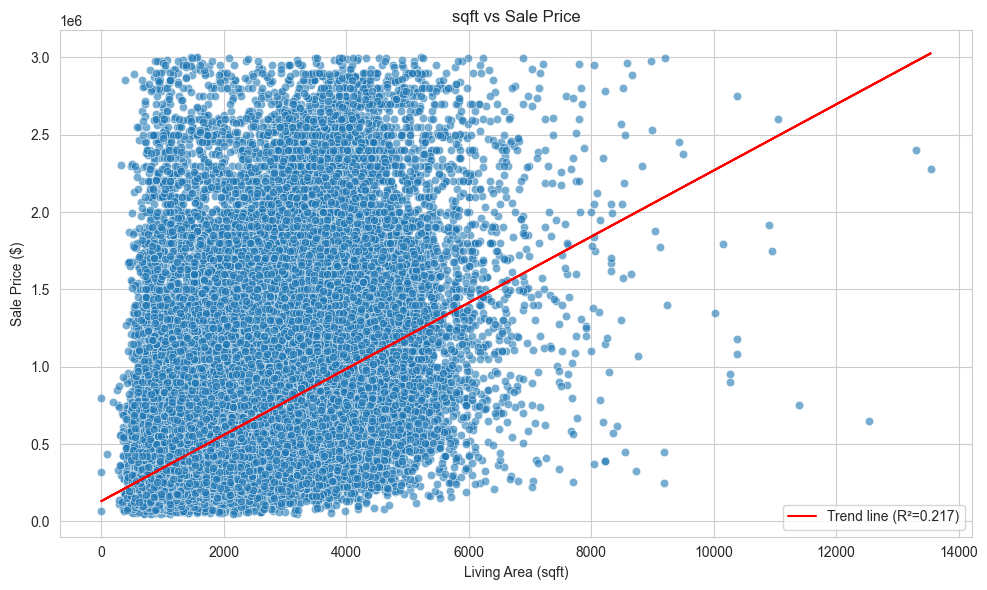

Correlation between sqft and sale_price: 0.466


In [16]:
# Scatterplot: Living Area vs SalePrice
if not train_df_raw.empty:
    # Check for different possible column names for living area
    possible_columns = ['sqft', 'gr_liv_area', 'GrLivArea', 'ground_living_area', 'GroundLivingArea', 'sqft_1']
    living_area_col = None
    
    for col in possible_columns:
        if col in train_df_raw.columns:
            living_area_col = col
            break
    
    if living_area_col is not None and 'sale_price' in train_df_raw.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=train_df_raw[living_area_col], y=train_df_raw['sale_price'], alpha=0.6)
        plt.title(f'{living_area_col} vs Sale Price')
        plt.xlabel('Living Area (sqft)')
        plt.ylabel('Sale Price ($)')
        
        # Add a trend line for better visualization
        import scipy.stats as stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(train_df_raw[living_area_col], train_df_raw['sale_price'])
        line = slope * train_df_raw[living_area_col] + intercept
        plt.plot(train_df_raw[living_area_col], line, 'r', label=f'Trend line (R²={r_value**2:.3f})')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Correlation between {living_area_col} and sale_price: {train_df_raw[living_area_col].corr(train_df_raw['sale_price']):.3f}")
    else:
        print("Error: Required columns not found in the dataset.")
        print("Available columns:", list(train_df_raw.columns))
        if living_area_col is None:
            print("Living area column not found. Tried:", possible_columns)
        if 'sale_price' not in train_df_raw.columns:
            print("Sale price column not found.")
else:
    print("Training data is empty. Cannot create scatterplot.")

### 5.9 Correlation Analysis with Log-Transformed Target
*Identify top features correlated with log-transformed sale price*

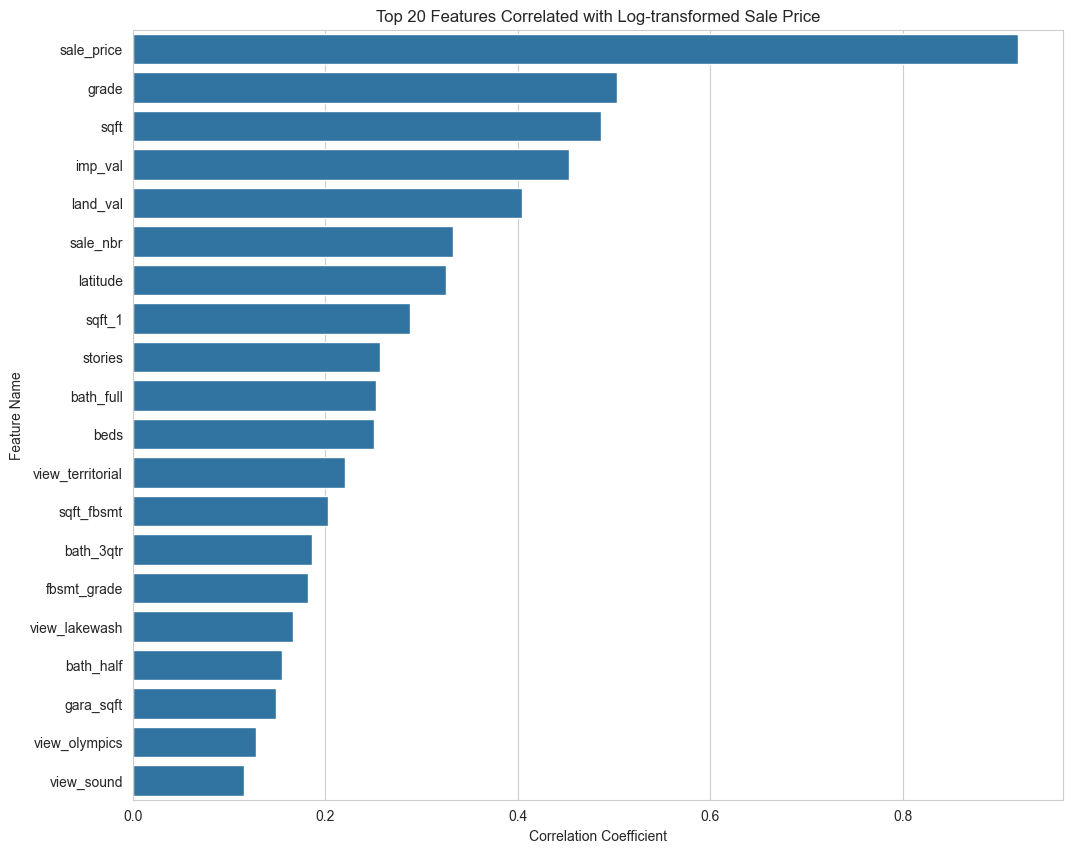

In [17]:
    # 5.2. Correlation Analysis
    df_train_for_corr = train_df_raw.copy()
    df_train_for_corr['log_sale_price'] = np.log1p(df_train_for_corr['sale_price'])

    corr_matrix = df_train_for_corr.select_dtypes(include=np.number).corr()

    top_corr_features = corr_matrix['log_sale_price'].abs().sort_values(ascending=False).index[1:21]

    plt.figure(figsize=(12, 10))
    sns.barplot(x=corr_matrix['log_sale_price'][top_corr_features], y=top_corr_features)
    plt.title('Top 20 Features Correlated with Log-transformed Sale Price')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Feature Name')
    plt.show()

## 6. Feature Engineering and Data Preprocessing
*Engineer new features and prepare data for model training*

In [18]:
# 6: Feature Engineering and Preprocessing
def feature_engineer(df):
    df_copy = df.copy()
    # Use a flexible format and coerce errors to NaT (Not a Time)
    df_copy['sale_date'] = pd.to_datetime(df_copy['sale_date'], format='mixed', errors='coerce')

    # Handle any dates that could not be parsed
    # A simple and robust strategy is to fill with the median date from the parsed dates
    if df_copy['sale_date'].isnull().any():
        median_date = df_copy['sale_date'].median()
        df_copy['sale_date'].fillna(median_date, inplace=True)

    df_copy['sale_year'] = df_copy['sale_date'].dt.year
    df_copy['sale_month'] = df_copy['sale_date'].dt.month
    df_copy['sale_dayofyear'] = df_copy['sale_date'].dt.dayofyear
    df_copy['house_age'] = df_copy['sale_year'] - df_copy['year_built']
    df_copy['years_since_reno'] = np.where((df_copy['year_reno'] > 0) & (df_copy['year_reno'] >= df_copy['year_built']), df_copy['sale_year'] - df_copy['year_reno'], 0)
    df_copy['was_renovated'] = (df_copy['years_since_reno'] > 0).astype(int)
    df_copy = df_copy.drop(columns=['sale_date', 'year_built', 'year_reno'])
    return df_copy

if not train_df_raw.empty:
    train_df_raw['log_sale_price'] = np.log1p(train_df_raw['sale_price'])
    TARGET = 'log_sale_price'
    FEATURES = [col for col in train_df_raw.columns if col not in ['id', 'sale_price', 'log_sale_price']]

    X = train_df_raw[FEATURES]
    y = train_df_raw[TARGET]
    X_test = test_df[[col for col in FEATURES if col in test_df.columns]]

    X = feature_engineer(X)
    X_test = feature_engineer(X_test)

    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

    # CRITICAL FIX: Fill NaN values in categorical features before type conversion.
    # CatBoost cannot handle NaN in categorical columns.
    for col in categorical_features:
        X[col] = X[col].fillna('missing')
        X_test[col] = X_test[col].fillna('missing')

    for col in categorical_features:
        X[col] = X[col].astype('category')
        X_test[col] = X_test[col].astype('category')

    preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    X[numerical_features] = preprocessor.fit_transform(X[numerical_features])
    X_test[numerical_features] = preprocessor.transform(X_test[numerical_features])

    print("Preprocessing complete.")
    del train_df_raw
    gc.collect()

Preprocessing complete.


## 7. Data Splitting for Conformal Prediction
*Split data into training and calibration sets for CQR methodology*

In [19]:
# 7: Data Splitting for Conformal Prediction
if 'X' in locals() and not X.empty:
    X_train_proper, X_calib, y_train_proper, y_calib = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split into training and calibration sets.")

Data split into training and calibration sets.


## 8. Model Training (LightGBM, XGBoost, CatBoost)
*Train ensemble of quantile regression models for lower and upper bounds*

In [20]:
# 8: Model Training
# Train all 6 models (3 base models x 2 quantiles).
if 'X_train_proper' in locals():
    alpha = 0.1
    q_lower = alpha / 2.0
    q_upper = 1 - (alpha / 2.0)

    # --- LightGBM ---
    print("Training LightGBM models...")
    lgbm_params = {'objective': 'quantile', 'metric': 'quantile', 'random_state': 42, 'n_estimators': 1000}
    lgbm_lower = lgb.LGBMRegressor(alpha=q_lower, **lgbm_params)
    lgbm_upper = lgb.LGBMRegressor(alpha=q_upper, **lgbm_params)
    lgbm_lower.fit(X_train_proper, y_train_proper, categorical_feature=categorical_features, eval_set=[(X_calib, y_calib)], callbacks=[lgb.early_stopping(100, verbose=False)])
    lgbm_upper.fit(X_train_proper, y_train_proper, categorical_feature=categorical_features, eval_set=[(X_calib, y_calib)], callbacks=[lgb.early_stopping(100, verbose=False)])

    # --- XGBoost ---
    print("Training XGBoost models...")
    # Convert categorical features to integer codes for XGBoost
    X_train_xgb = X_train_proper.copy()
    X_calib_xgb = X_calib.copy()
    for col in categorical_features:
        X_train_xgb[col] = X_train_xgb[col].cat.codes
        X_calib_xgb[col] = X_calib_xgb[col].cat.codes
    xgb_params = {'objective': 'reg:quantileerror', 'random_state': 42, 'n_estimators': 1000, 'tree_method': 'hist'}
    xgb_lower = xgb.XGBRegressor(quantile_alpha=q_lower, **xgb_params)
    xgb_upper = xgb.XGBRegressor(quantile_alpha=q_upper, **xgb_params)
    # This simplified fit call is more robust across different environments.
    xgb_lower.fit(X_train_xgb, y_train_proper, eval_set=[(X_calib_xgb, y_calib)], verbose=False)
    xgb_upper.fit(X_train_xgb, y_train_proper, eval_set=[(X_calib_xgb, y_calib)], verbose=False)

    # --- CatBoost ---
    print("Training CatBoost models...")
    # Option 1: Disable logging completely by setting train_dir=None
    cat_params_lower = {'loss_function': f'Quantile:alpha={q_lower}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': None}
    cat_params_upper = {'loss_function': f'Quantile:alpha={q_upper}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': None}

    # Option 2: Or specify a custom directory (uncomment the lines below and comment out the ones above)
    # cat_params_lower = {'loss_function': f'Quantile:alpha={q_lower}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': './ml_model/catboost_logs'}
    # cat_params_upper = {'loss_function': f'Quantile:alpha={q_upper}', 'iterations': 1000, 'verbose': 0, 'random_seed': 42, 'train_dir': './ml_model/catboost_logs'}

    cat_lower = cb.CatBoostRegressor(**cat_params_lower)
    cat_upper = cb.CatBoostRegressor(**cat_params_upper)

    cat_lower.fit(X_train_proper, y_train_proper, cat_features=categorical_features, eval_set=[(X_calib, y_calib)], early_stopping_rounds=100)
    cat_upper.fit(X_train_proper, y_train_proper, cat_features=categorical_features, eval_set=[(X_calib, y_calib)], early_stopping_rounds=100)

    print("All models trained.")

Training LightGBM models...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11999
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 48
[LightGBM] [Info] Start training from score 12.128117
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039722 second

## 9. Ensemble CQR Calibration and Evaluation
*Calibrate prediction intervals using conformal prediction framework*

In [21]:
# 9: Ensemble CQR Calibration and Evaluation
if 'lgbm_lower' in locals():
    # 1. Get predictions from all models on the calibration set
    lgbm_cal_preds_lower = lgbm_lower.predict(X_calib)
    lgbm_cal_preds_upper = lgbm_upper.predict(X_calib)
    xgb_cal_preds_lower = xgb_lower.predict(X_calib_xgb) # Use encoded data for XGBoost
    xgb_cal_preds_upper = xgb_upper.predict(X_calib_xgb) # Use encoded data for XGBoost
    cat_cal_preds_lower = cat_lower.predict(X_calib)
    cat_cal_preds_upper = cat_upper.predict(X_calib)

    # 2. Average the predictions to create the ensemble interval
    ensemble_cal_lower = np.mean([lgbm_cal_preds_lower, xgb_cal_preds_lower, cat_cal_preds_lower], axis=0)
    ensemble_cal_upper = np.mean([lgbm_cal_preds_upper, xgb_cal_preds_upper, cat_cal_preds_upper], axis=0)

    # 3. Calculate conformity scores for the ENSEMBLE
    conformity_scores = np.maximum(ensemble_cal_lower - y_calib, y_calib - ensemble_cal_upper)

    # 4. Calculate the correction term 'q'
    n_calib = len(X_calib)
    q_level = np.ceil((1 - alpha) * (n_calib + 1)) / n_calib
    q = np.quantile(conformity_scores, q_level, interpolation='higher')
    print(f"Calculated Ensemble CQR correction factor (q): {q:.4f}")

    # 5. Apply correction and evaluate
    final_lower_bound_log = ensemble_cal_lower - q
    final_upper_bound_log = ensemble_cal_upper + q

    y_calib_orig = np.expm1(y_calib)
    final_lower_bound_orig = np.expm1(final_lower_bound_log)
    final_upper_bound_orig = np.expm1(final_upper_bound_log)

    coverage = np.mean((y_calib_orig >= final_lower_bound_orig) & (y_calib_orig <= final_upper_bound_orig))
    winkler = mean_winkler_score(y_calib_orig, final_lower_bound_orig, final_upper_bound_orig)

    print(f"\nTarget Coverage: {1-alpha:.2f}")
    print(f"Ensemble Empirical Coverage on Hold-out Set: {coverage:.4f}")
    print(f"Ensemble Mean Winkler Score on Hold-out Set: {winkler:,.2f}")

Calculated Ensemble CQR correction factor (q): 0.0019

Target Coverage: 0.90
Ensemble Empirical Coverage on Hold-out Set: 0.9001
Ensemble Mean Winkler Score on Hold-out Set: 332,261.14


## 10. Model Performance Visualization

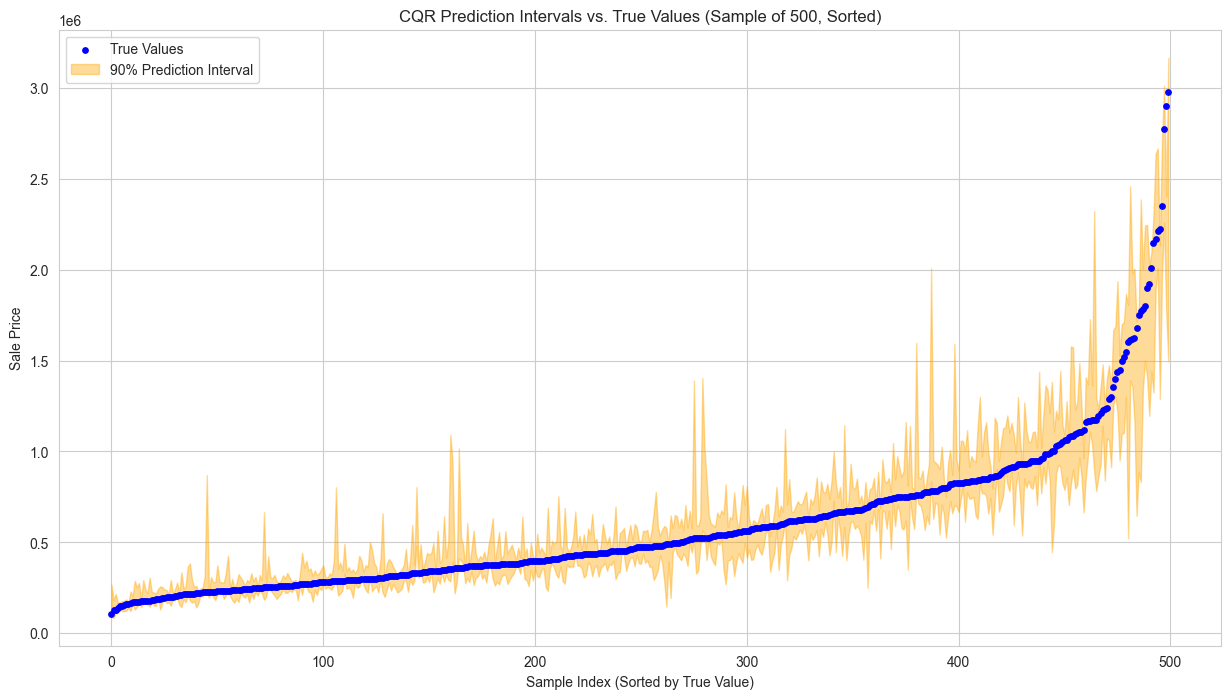

In [22]:
# 10: Model Performance Visualization
if 'y_calib_orig' in locals():
    # 10.1. Prediction Interval Visualization
    results_df = pd.DataFrame({
        'y_true': y_calib_orig,
        'lower': final_lower_bound_orig,
        'upper': final_upper_bound_orig
    }).sort_values('y_true').reset_index(drop=True)

    sample_results = results_df.sample(n=min(500, len(results_df)), random_state=42).sort_values('y_true')

    plt.figure(figsize=(15, 8))
    plt.scatter(range(len(sample_results)), sample_results['y_true'], color='blue', label='True Values', s=15, zorder=3)
    plt.fill_between(
        range(len(sample_results)),
        sample_results['lower'],
        sample_results['upper'],
        color='orange',
        alpha=0.4,
        label='90% Prediction Interval',
        zorder=1
    )
    plt.title('CQR Prediction Intervals vs. True Values (Sample of 500, Sorted)')
    plt.xlabel('Sample Index (Sorted by True Value)')
    plt.ylabel('Sale Price')
    plt.legend()
    plt.show()


### 10.2 Feature Importance Analysis
*Compare feature importance across different models*

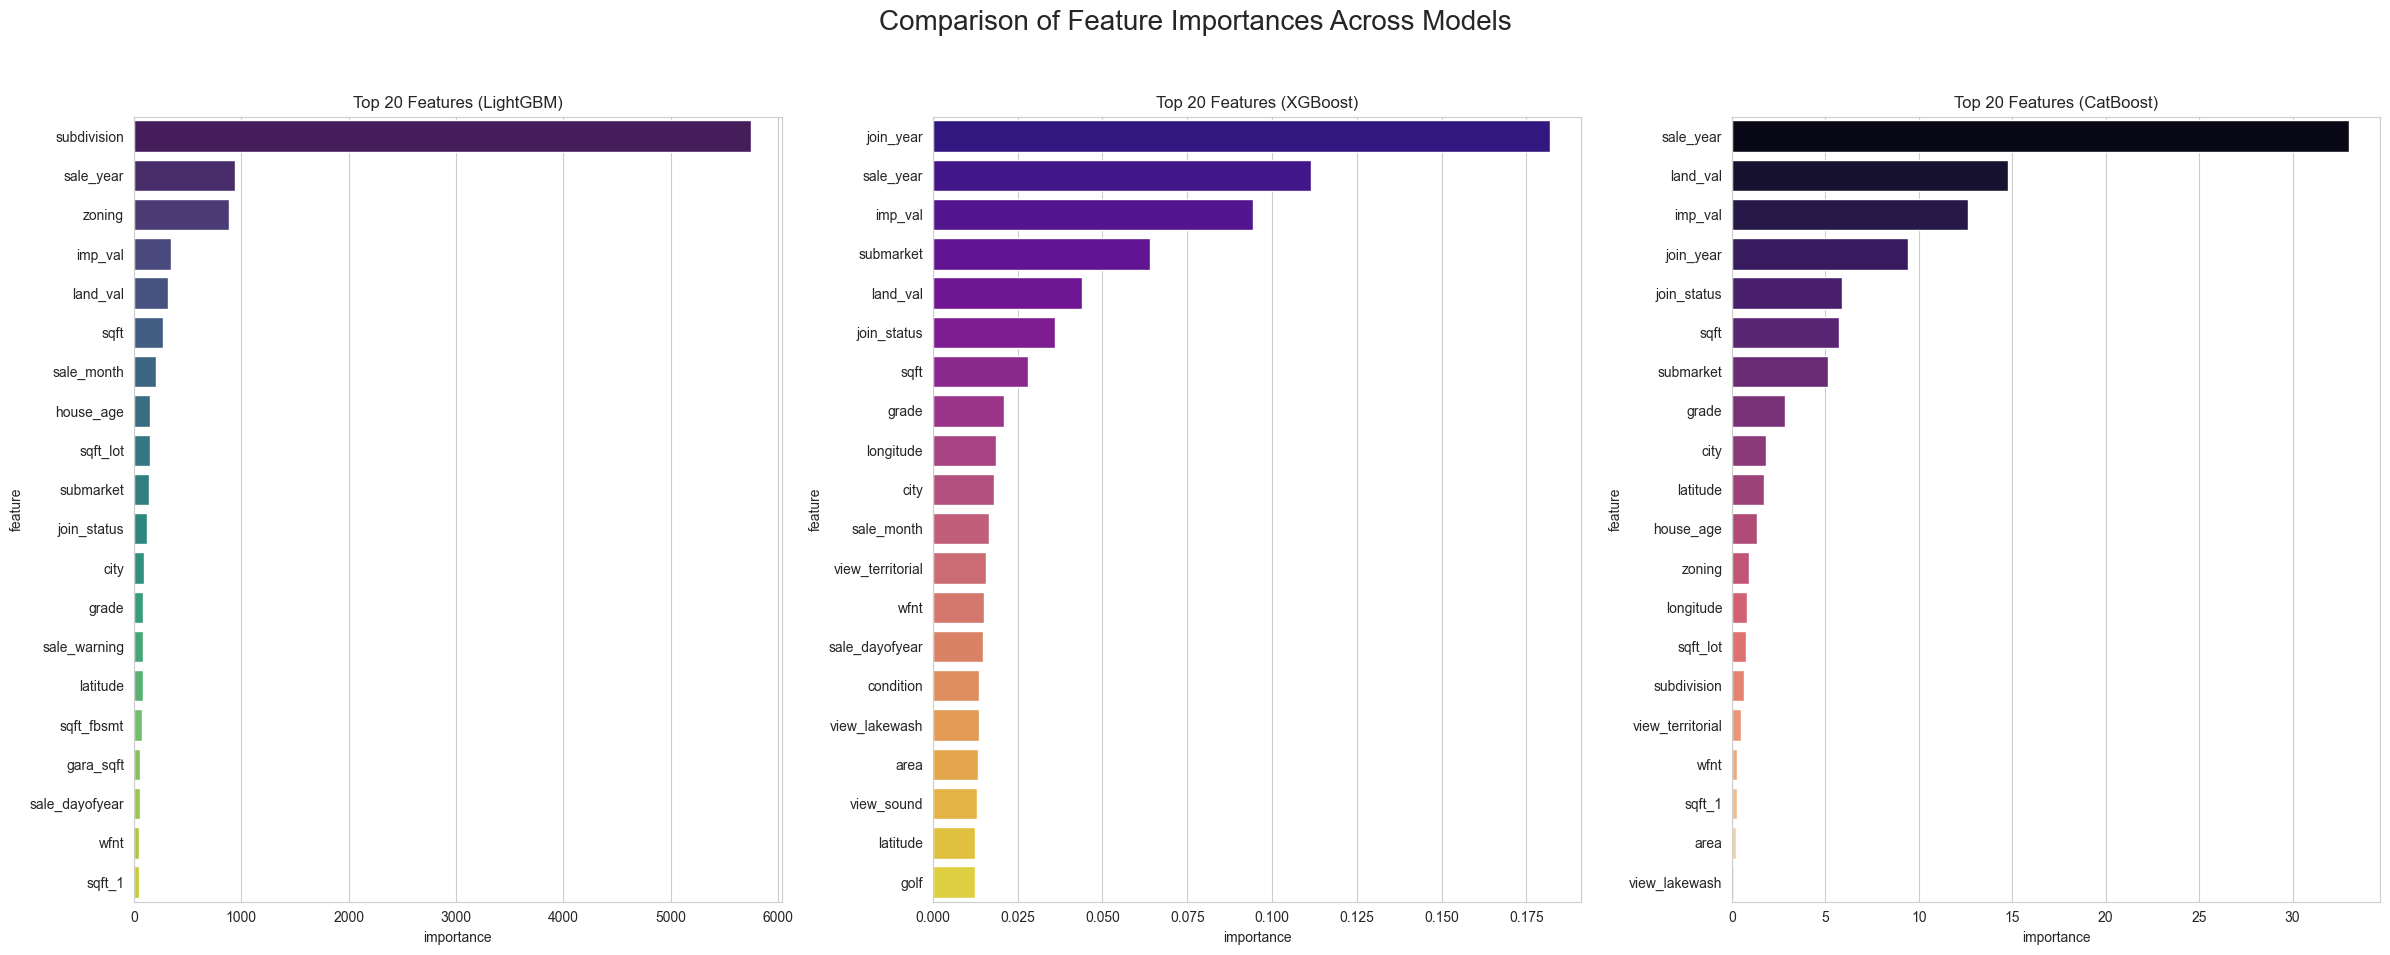

In [23]:

    # 10.2. Feature Importance Plots
    fig, axes = plt.subplots(1, 3, figsize=(24, 10))

    # LightGBM Feature Importance
    lgbm_importances = pd.DataFrame({'feature': X.columns, 'importance': lgbm_upper.feature_importances_}).sort_values('importance', ascending=False).head(20)
    sns.barplot(x='importance', y='feature', data=lgbm_importances, ax=axes[0], palette='viridis')
    axes[0].set_title('Top 20 Features (LightGBM)')

    # XGBoost Feature Importance
    xgb_importances = pd.DataFrame({'feature': X.columns, 'importance': xgb_upper.feature_importances_}).sort_values('importance', ascending=False).head(20)
    sns.barplot(x='importance', y='feature', data=xgb_importances, ax=axes[1], palette='plasma')
    axes[1].set_title('Top 20 Features (XGBoost)')

    # CatBoost Feature Importance
    cat_importances = pd.DataFrame({'feature': X.columns, 'importance': cat_upper.feature_importances_}).sort_values('importance', ascending=False).head(20)
    sns.barplot(x='importance', y='feature', data=cat_importances, ax=axes[2], palette='magma')
    axes[2].set_title('Top 20 Features (CatBoost)')

    plt.suptitle('Comparison of Feature Importances Across Models', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 10.3 Model Agreement Analysis
*Analyze prediction consistency between models*

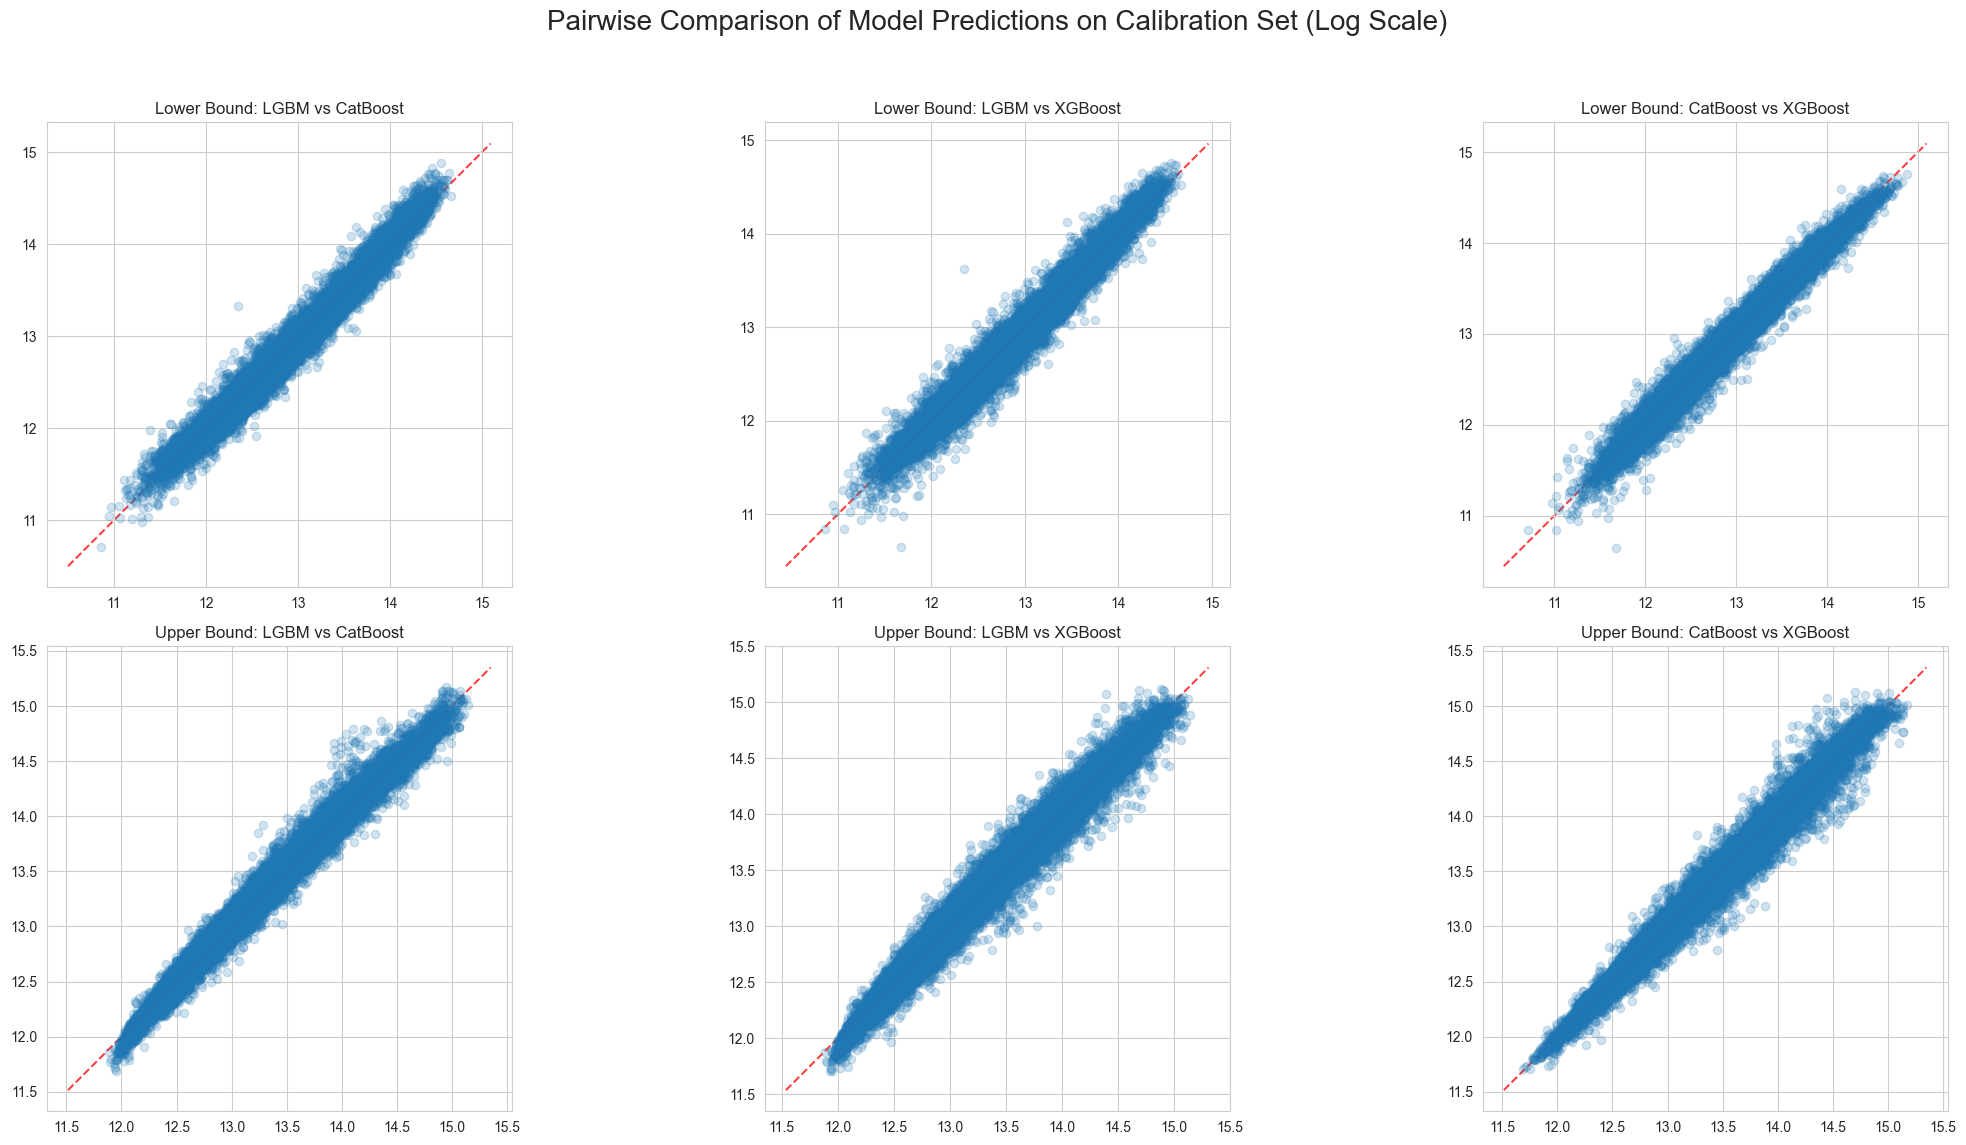

In [24]:
    # 10.3. Model Agreement Scatter Plots
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))

    # Lower Bound Comparisons
    axes[0, 0].scatter(lgbm_cal_preds_lower, cat_cal_preds_lower, alpha=0.2)
    axes[0, 0].set_title('Lower Bound: LGBM vs CatBoost')
    axes[0, 1].scatter(lgbm_cal_preds_lower, xgb_cal_preds_lower, alpha=0.2)
    axes[0, 1].set_title('Lower Bound: LGBM vs XGBoost')
    axes[0, 2].scatter(cat_cal_preds_lower, xgb_cal_preds_lower, alpha=0.2)
    axes[0, 2].set_title('Lower Bound: CatBoost vs XGBoost')

    # Upper Bound Comparisons
    axes[1, 0].scatter(lgbm_cal_preds_upper, cat_cal_preds_upper, alpha=0.2)
    axes[1, 0].set_title('Upper Bound: LGBM vs CatBoost')
    axes[1, 1].scatter(lgbm_cal_preds_upper, xgb_cal_preds_upper, alpha=0.2)
    axes[1, 1].set_title('Upper Bound: LGBM vs XGBoost')
    axes[1, 2].scatter(cat_cal_preds_upper, xgb_cal_preds_upper, alpha=0.2)
    axes[1, 2].set_title('Upper Bound: CatBoost vs XGBoost')

    for ax_row in axes:
        for ax in ax_row:
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()]),
            ]
            ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
            ax.set_aspect('equal', adjustable='box')
            ax.grid(True)

    plt.suptitle('Pairwise Comparison of Model Predictions on Calibration Set (Log Scale)', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 11. Final Model Training and Test Predictions
*Retrain models on full dataset and generate test predictions*

In [25]:
# 11: Final Training and Submission File Generation
if 'X' in locals():
    print("Retraining all models on the full dataset...")

    lgbm_params_final = {'objective': 'quantile', 'metric': 'quantile', 'random_state': 42, 'n_estimators': lgbm_lower.best_iteration_}
    final_lgbm_lower = lgb.LGBMRegressor(alpha=q_lower, **lgbm_params_final).fit(X, y, categorical_feature=categorical_features)
    lgbm_params_final['n_estimators'] = lgbm_upper.best_iteration_
    final_lgbm_upper = lgb.LGBMRegressor(alpha=q_upper, **lgbm_params_final).fit(X, y, categorical_feature=categorical_features)

    # Prepare full data for final XGBoost training
    X_xgb_full = X.copy()
    X_test_xgb = X_test.copy()
    for col in categorical_features:
        X_xgb_full[col] = X_xgb_full[col].cat.codes
        X_test_xgb[col] = X_test_xgb[col].cat.codes

    # Train final XGBoost models on the full encoded data
    xgb_params_final = {'objective': 'reg:quantileerror', 'random_state': 42, 'n_estimators': 1000, 'tree_method': 'hist'}
    final_xgb_lower = xgb.XGBRegressor(quantile_alpha=q_lower, **xgb_params_final).fit(X_xgb_full, y)
    final_xgb_upper = xgb.XGBRegressor(quantile_alpha=q_upper, **xgb_params_final).fit(X_xgb_full, y)

    # CatBoost final training with controlled logging
    cat_params_final_lower = {'loss_function': f'Quantile:alpha={q_lower}', 'iterations': cat_lower.get_best_iteration(), 'verbose': 0, 'random_seed': 42, 'train_dir': None}
    final_cat_lower = cb.CatBoostRegressor(**cat_params_final_lower).fit(X, y, cat_features=categorical_features)

    cat_params_final_upper = {'loss_function': f'Quantile:alpha={q_upper}', 'iterations': cat_upper.get_best_iteration(), 'verbose': 0, 'random_seed': 42, 'train_dir': None}
    final_cat_upper = cb.CatBoostRegressor(**cat_params_final_upper).fit(X, y, cat_features=categorical_features)

    print("Final model training complete.")

Retraining all models on the full dataset...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12532
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 48
[LightGBM] [Info] Start training from score 12.128117
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

In [26]:
    # --- Generate Submission ---
    print("Generating predictions for the test set...")
    lgbm_test_lower = final_lgbm_lower.predict(X_test)
    lgbm_test_upper = final_lgbm_upper.predict(X_test)
    xgb_test_lower = final_xgb_lower.predict(X_test_xgb)
    xgb_test_upper = final_xgb_upper.predict(X_test_xgb)
    cat_test_lower = final_cat_lower.predict(X_test)
    cat_test_upper = final_cat_upper.predict(X_test)

    # Ensemble the test predictions
    ensemble_test_lower = np.mean([lgbm_test_lower, xgb_test_lower, cat_test_lower], axis=0)
    ensemble_test_upper = np.mean([lgbm_test_upper, xgb_test_upper, cat_test_upper], axis=0)

    # Apply the correction factor 'q' found during calibration
    final_test_lower_log = ensemble_test_lower - q
    final_test_upper_log = ensemble_test_upper + q

    # Transform back to original scale
    final_test_lower_orig = np.expm1(final_test_lower_log)
    final_test_upper_orig = np.expm1(final_test_upper_log)

    # Post-processing
    final_test_lower_orig = np.maximum(0, final_test_lower_orig)
    final_test_upper_orig = np.maximum(final_test_lower_orig, final_test_upper_orig)

    # Create submission file
    test_df_ids = pd.read_csv(test_path, usecols=['id'])
    submission_df = pd.DataFrame({'id': test_df_ids['id'], 'pi_lower': final_test_lower_orig, 'pi_upper': final_test_upper_orig})

    submission_filename = '20282106_ensemble_submission-v6.csv'
    submission_df.to_csv(submission_filename, index=False)

    print(f"\nSubmission file '{submission_filename}' created successfully!")
    print(f"Saved to: {os.path.abspath(submission_filename)}")

    try:
        display(submission_df.head())
    except NameError:
        print(submission_df.head())

Generating predictions for the test set...

Submission file '20282106_ensemble_submission-v6.csv' created successfully!
Saved to: d:\Projects\house-price-prediction-app\20282106_ensemble_submission-v6.csv


,id,pi_lower,pi_upper
0,200000,800730.493788,1.120971e+06
1,200001,517861.323001,7.725888e+05
2,200002,443403.014159,6.957493e+05
3,200003,322607.775184,4.455374e+05
4,200004,380405.202610,7.395563e+05


## 12. Model Artifacts Export
*Save trained models, preprocessor, and configuration for deployment*

In [27]:
# 12: Save Models and Preprocessor for Application ---
import joblib
import json
import os

print("Saving models and artifacts....")

# Define the directory to save the artifacts
artifact_path = os.path.join(os.getcwd(), 'ml_model-artifacts')
os.makedirs(artifact_path, exist_ok=True)

# Save the 6 trained models
joblib.dump(final_lgbm_lower, os.path.join(artifact_path, 'lgbm_lower.pkl'))
joblib.dump(final_lgbm_upper, os.path.join(artifact_path, 'lgbm_upper.pkl'))
joblib.dump(final_xgb_lower, os.path.join(artifact_path, 'xgb_lower.pkl'))
joblib.dump(final_xgb_upper, os.path.join(artifact_path, 'xgb_upper.pkl'))
joblib.dump(final_cat_lower, os.path.join(artifact_path, 'cat_lower.pkl'))
joblib.dump(final_cat_upper, os.path.join(artifact_path, 'cat_upper.pkl'))

# Save the preprocessor pipeline
joblib.dump(preprocessor, os.path.join(artifact_path, 'preprocessor.pkl'))

# Save the feature lists and the 'q' value in a JSON file for easy loading
artifacts_to_save = {
    'q_value': q,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'features_order': list(X.columns) # Save the exact order of columns
}

with open(os.path.join(artifact_path, 'model_config.json'), 'w') as f:
    json.dump(artifacts_to_save, f)

print(f"All artifacts saved to {artifact_path}")

Saving models and artifacts....
All artifacts saved to d:\Projects\house-price-prediction-app\ml_model-artifacts
